# A TUTORIAL ON GRADIENT BOOSTING REGRESSION USING XGBoost

by Sebastian T. Glavind, August, 2020

# Introduction

In this tutorial, we will consider how to define, train, and predict with gradient boosted decision trees using `XGBoost`. First, we will consider how to formulate a single-output regression with `XGBoost` and elaborate on how we may extend the model to a multi-output setting. Then, we will see how to choose the hyperparameters using Bayesian optimization with a Gaussian process prior. The interested reader is referred to e.g. the textbook of Hastie et al. (2009) for an introduction to gradient boosting (machines), Chen and Guestrin (2016) for a reference on `XGBoost`, and Shahriari et al. (2016) for a review on Bayesian optimization.

We will consider a small data set in the tutorial, i.e. the Boston housing data set, so that training can be performed on a standard computer.

***
T. Hastie, R. Tibshirani, J. H. Friedman, The Elements of Statistical Learning, Springer New York, 2009.

T. Chen, C. Guestrin, XGBoost: A scalable tree boosting system, in: Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, ACM, 2016, pp. 785-794, http://dx.doi.org/10.1145/2939672.2939785

B. Shahriari, K. Swersky, Z. Wang, R. P. Adams, N. de Freitas, Taking the human out of the loop: A review of bayesian optimization, in: Proceedings of the IEEE, Vol. 104, 2016, pp. 148-175. 
***

# Prelude

In [1]:
import sklearn.utils
import sklearn.metrics
import sklearn.model_selection
import sklearn.decomposition
from sklearn.datasets import load_boston
import pandas as pd
import xgboost as xgb
import GPyOpt
import pickle
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Single-output gradient boosted decision trees


## Data set

In this tutorial, we will consider the Boston housing data set, see e.g. https://www.kaggle.com/c/boston-housing, which ships with `scikit-learn`. The data set reflect properties of houses in the suburbs of Boston and is concerned with the modeling of house prices, see description below.

In [2]:
BostonData = load_boston()
print(BostonData['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

### Define train and test data

In [3]:
Xraw, yraw = BostonData['data'], BostonData['target']
Xtrain, Xtest, ytrain, ytest = sklearn.model_selection.train_test_split(Xraw, yraw, train_size=.8, shuffle=True, 
                                                                  random_state=1)

### Standardize features and output

In [4]:
# Standardize features
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(Xtrain)
sXtrain = scaler.transform(Xtrain)
sXtest = scaler.transform(Xtest)

In [5]:
# Standardize outputs - no needed for single-outputs
scaler_y = sklearn.preprocessing.StandardScaler()
scaler_y.fit(ytrain.reshape(-1,1) )
sytrain = scaler_y.transform(ytrain.reshape(-1,1))
sytest = scaler_y.transform(ytest.reshape(-1,1))

### Principal component analysis

See e.g. Geron (2019) - decision tree prefer othogonal features.

***
A. Geron, Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow: Concepts, tools, and techniques to build intelligent systems. O’Reilly Media, 2019.
***

In [6]:
# PCA of standardized features
pca_trans = sklearn.decomposition.PCA()
tXtrain = pca_trans.fit(sXtrain)
tXtrain = pca_trans.transform(sXtrain)
tXtest = pca_trans.transform(sXtest)

## XGBoost - no feature transformation

In [7]:
xgb_reg = xgb.XGBRegressor(seed=0)
xgb_reg.fit(Xtrain,sytrain)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, subsample=1,
             tree_method=None, validate_parameters=False, verbosity=None)

### Model evaluation

In [8]:
print('Training data')
pred_train = xgb_reg.predict(Xtrain)
print('mse:', sklearn.metrics.mean_squared_error(pred_train, sytrain) )
print('Test data')
pred_test = xgb_reg.predict(Xtest)
print('mse:', sklearn.metrics.mean_squared_error(pred_test, sytest) )

Training data
mse: 2.8382549543093897e-06
Test data
mse: 0.09922095203124541


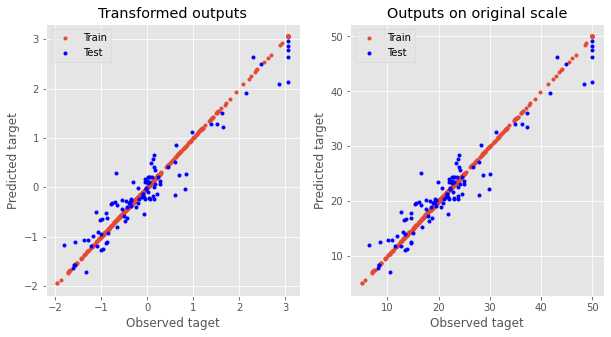

In [9]:
fig, ax = plt.subplots(1,2,figsize=(10, 5));
ax[0].plot(sytrain, pred_train,'.');
ax[0].plot(sytest, pred_test,'b.');
ax[0].set_xlabel('Observed taget');
ax[0].set_ylabel('Predicted target');
ax[0].set_title('Transformed outputs');
ax[0].legend(['Train','Test']);
# plt.axis([-2, 3, -2, 3]);

ax[1].plot(ytrain, scaler_y.inverse_transform(pred_train),'.');
ax[1].plot(ytest, scaler_y.inverse_transform(pred_test),'b.');
ax[1].set_xlabel('Observed taget');
ax[1].set_ylabel('Predicted target');
ax[1].set_title('Outputs on original scale');
ax[1].legend(['Train','Test']);
# plt.axis([-2, 3, -2, 3]);

We see that the model (over-)fit the training data, resulting in an almost perfect fit on that data. The error on the test data is orders of magnitude larger, thus indicating an overfit on the training data, but the residuals still look reasonable, except for the upper tail. We will address the overfitting issue in by optimizing the model hyper-parameters, see the section on Bayesian optimization.

## XGBoost - feature pre-processing with PCA

In [10]:
xgb_reg_t = xgb.XGBRegressor(seed=0)
xgb_reg_t.fit(tXtrain, sytrain)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, subsample=1,
             tree_method=None, validate_parameters=False, verbosity=None)

### Model evaluation

In [11]:
print('Training data')
pred_train_t = xgb_reg_t.predict(tXtrain)
print('mse:', sklearn.metrics.mean_squared_error(pred_train_t, sytrain) )
print('Test data')
pred_test_t = xgb_reg_t.predict(tXtest)
print('mse:', sklearn.metrics.mean_squared_error(pred_test_t, sytest) )

Training data
mse: 2.102652363018083e-06
Test data
mse: 0.12819173705618314


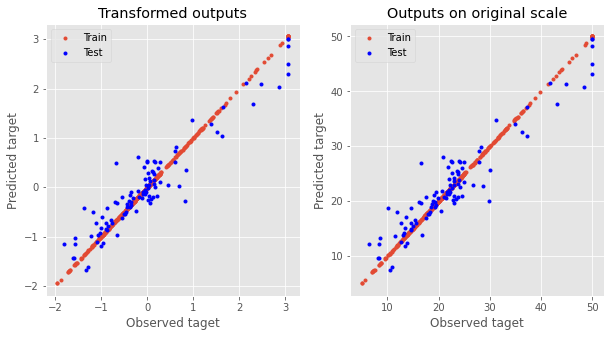

In [12]:
fig, ax = plt.subplots(1,2,figsize=(10, 5));
ax[0].plot(sytrain, pred_train_t,'.');
ax[0].plot(sytest, pred_test_t,'b.');
ax[0].set_xlabel('Observed taget');
ax[0].set_ylabel('Predicted target');
ax[0].set_title('Transformed outputs');
ax[0].legend(['Train','Test']);
# plt.axis([-2, 3, -2, 3]);

ax[1].plot(ytrain, scaler_y.inverse_transform(pred_train_t),'.');
ax[1].plot(ytest, scaler_y.inverse_transform(pred_test_t),'b.');
ax[1].set_xlabel('Observed taget');
ax[1].set_ylabel('Predicted target');
ax[1].set_title('Outputs on original scale');
ax[1].legend(['Train','Test']);
# plt.axis([-2, 3, -2, 3]);

We see that the model (over-)fit the training data even more in this case, resulting again in an almost perfect fit on that data. The error on the test data is orders of magnitude larger, thus indicating an overfit on the training data, but the residuals still look reasonable, except in the tails. We will address the overfitting issue in by optimizing the model hyper-parameters, see the section on Bayesian optimization.


# Multi-output gradient boosted decision trees

At the present stage, `XGBoost` does not support multi-output tasks, but a work around is to use the functionalities of `sklearn`, specifically `MultiOutputRegressor`, to trains one regressor per target, e.g.

```python
model = MultiOutputRegressor(XGBRegressor())
model.fit(Xtrain, ytrain)
```


# Bayesian optimization with GPyOpt

In this section, we will try to reduce overfitting in order to define a model that generalizes better by optimizing the hyper-parameters of the model. The hyper-parameters optimization in this section will be performed using Bayesian optimization with a Gaussian process prior, see e.g. Shahriari et al. (2016) for a reference. In this regard, we will use the functionalities of `GPyOpt` in the implementation of Bayesian optimization, see https://github.com/SheffieldML/GPyOpt.

***
B. Shahriari, K. Swersky, Z. Wang, R. P. Adams, N. de Freitas, Taking the human out of the loop: A review of Bayesian optimization, in: Proceedings of the IEEE, Vol. 104, 2016, pp. 148-175.
***

In [13]:
# from xgboost import XGBRegressor
from GPyOpt.methods import BayesianOptimization
from sklearn.model_selection import cross_val_score
import os

In [14]:
bds = [{'name': 'learning_rate', 'type': 'continuous', 'domain': (0.001, 0.3)}, # see Brownlee (2020) - xgboost
        {'name': 'max_depth', 'type': 'discrete', 'domain': (2, 4, 6, 8, 10, 12)}, # see Brownlee (2020) - xgboost
        {'name': 'min_child_weight', 'type': 'discrete', 'domain': (1, 10)}]# see Brownlee (2020) - xgboost

maximum_boosting_rounds = 1000
early_stop_rounds = 10
gamma = 0 # see Brownlee (2020) - xgboost

# Optimization objective 
os.remove("GBMReg_OptIt.csv")
def cv_score(parameters):
    parameters = parameters[0]
    cv = sklearn.model_selection.KFold(n_splits=5, shuffle=True, random_state=7)
    cv_scores = []
    cv_iterations = []
    for train_index, test_index in cv.split(Xtrain, ytrain):
        # K-fold
        X_train, X_test = Xtrain[train_index,:], Xtrain[test_index,:]
        y_train, y_test = ytrain[train_index], ytrain[test_index]

        # Standardize features
        scaler = sklearn.preprocessing.StandardScaler()
        scaler.fit(X_train)
        sX_train = scaler.transform(X_train)
        sX_test = scaler.transform(X_test)

        # PCA of standardized features
        pca_trans = sklearn.decomposition.PCA()
        tX_train = pca_trans.fit(sX_train)
        tX_train = pca_trans.transform(sX_train)
        tX_test = pca_trans.transform(sX_test)
        
        # Standardize outputs - no needed for single-outputs
        scaler_y = sklearn.preprocessing.StandardScaler()
        scaler_y.fit(y_train.reshape(-1,1) )
        sy_train = scaler_y.transform(y_train.reshape(-1,1))
        sy_test = scaler_y.transform(y_test.reshape(-1,1))

        # Fit classifier
        eval_set = [(tX_test, sy_test)]
        xgb_regr = xgb.XGBRegressor(learning_rate=parameters[0], 
                                    gamma=gamma, 
                                    max_depth=int(parameters[1]),
                                    n_estimators=maximum_boosting_rounds,
                                    min_child_weight=int(parameters[2]),
                                    objective='reg:squarederror')
        xgb_regr.fit(tX_train, sy_train, early_stopping_rounds=early_stop_rounds, 
                     eval_metric='rmse', eval_set=eval_set, verbose=False)

        # score for fold i
        cv_scores_i = xgb_regr.evals_result()['validation_0']['rmse']
        cv_score_min_i = np.min(cv_scores_i)
        cv_scores.append(cv_score_min_i)
        
        cv_iterations_min_i = np.argmin(cv_scores_i)
        cv_iterations.append(cv_iterations_min_i)

    cv_score = np.mean(cv_scores)
    cv_score = np.array(cv_score)
    cv_iteration = np.mean(cv_iterations)
    print(cv_score, cv_iteration)
    # write results to output file 
    outF = open("GBMReg_OptIt.csv", "a")
    outF.write(str(cv_score) + ',' + str(cv_iteration) + '\n')
    outF.close()
    
    return cv_score

# parameters = list([[0.1, 4, 4]])
# cv_score(parameters)

optimizer = BayesianOptimization(f=cv_score, 
                                 domain=bds,
                                 model_type='GP',
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.01,
                                 exact_feval=True, 
                                 normalize_Y=True,
                                 acquisition_optimizer_type='lbfgs', 
                                 model_update_interval=1, 
                                 evaluator_type='sequential',
                                 maximize=False, # minimizing the score
                                 num_cores=1,
                                 initial_design_numdata=10,
                                 initial_design_type='random')
optimizer.run_optimization(max_iter=100)

0.45482480000000003 91.4
0.4753216 28.0
0.4566212 146.4
0.5150024 742.4
0.46248939999999994 94.0
0.4867798 29.0
0.4661706 47.8
0.46362760000000003 166.8
0.48273520000000003 46.2
0.47825999999999996 69.2
0.4813396 66.0
0.4500235999999999 66.6
0.46131340000000004 53.2
0.46936 34.4
0.6780322 999.0
0.4705158 50.6
0.4909324 731.2
0.4694708 22.4
0.44881779999999993 48.8
0.4742844 34.6
0.46043979999999995 87.8
0.47675920000000005 121.6
0.6588963999999999 999.0
0.4852674 28.6
0.44931400000000005 47.8
0.4825316 160.2
0.479409 48.6
0.48032119999999995 58.0
0.48049220000000004 134.0
0.47382300000000005 122.2
0.47694980000000003 63.0
0.6812924 999.0
0.4568709999999999 61.4
0.4675212 70.6
0.48792559999999996 338.2
0.477236 46.0
0.48285520000000004 93.4
0.6805316000000001 999.0
0.48276639999999993 77.2
0.47820819999999997 173.2
0.4924334 30.8
0.6541452000000001 999.0
0.4872742 59.8
0.4725072 73.0
0.7562441999999999 999.0
0.4787068 113.4
0.6528339999999999 999.0
0.48398340000000006 38.2
0.48108319999

### Convergence plots for the optimization

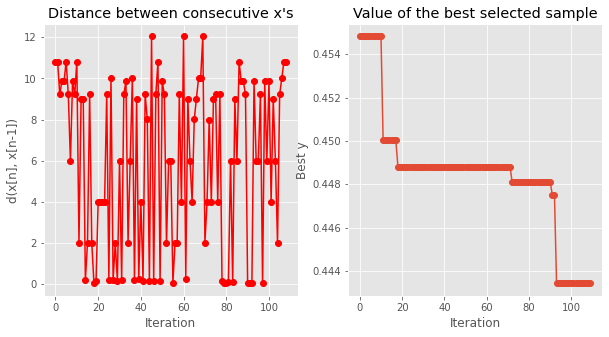

In [15]:
optimizer.plot_convergence()

### Optimal parameter setting and corresponding model

In [16]:
optOutFile = pd.read_csv("GBMReg_OptIt.csv", sep=',', names=np.array(['rmse', 'avg. it']))
argminY = np.argmin(optimizer.Y)
nTrees_opt = int(optOutFile['avg. it'][argminY])
print('avg. no. of trees at optimal score', nTrees_opt, (argminY, optOutFile['rmse'][argminY]))

avg. no. of trees at optimal score 133 (93, 0.4434252)


In [17]:
params_opt = (optimizer.x_opt); print(params_opt)
model_opt = xgb.XGBRegressor(learning_rate=params_opt[0],
                             gamma=gamma,
                             max_depth=int(params_opt[1]),
                             n_estimators=nTrees_opt,
                             min_child_weight=int(params_opt[2]),
                             objective='reg:squarederror', 
                             seed=0)
model_opt.fit(tXtrain,sytrain)

[ 0.0930387  4.        10.       ]


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.09303869881909223, max_delta_step=0, max_depth=4,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             n_estimators=133, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, subsample=1,
             tree_method=None, validate_parameters=False, verbosity=None)

### Model evaluation

In [18]:
print('Training data')
pred_train_opt = model_opt.predict(tXtrain)
print('mse:', sklearn.metrics.mean_squared_error(pred_train_opt, sytrain) )
print('Test data')
pred_test_opt = model_opt.predict(tXtest)
print('mse:', sklearn.metrics.mean_squared_error(pred_test_opt, sytest) )

Training data
mse: 0.016684671217474235
Test data
mse: 0.14699124706861838


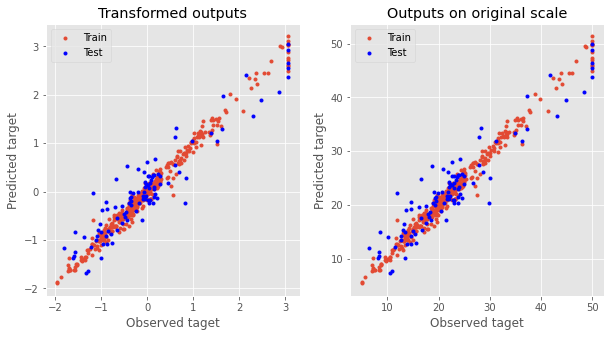

In [19]:
fig, ax = plt.subplots(1,2,figsize=(10, 5));
ax[0].plot(sytrain, pred_train_opt,'.');
ax[0].plot(sytest, pred_test_opt,'b.');
ax[0].set_xlabel('Observed taget');
ax[0].set_ylabel('Predicted target');
ax[0].set_title('Transformed outputs');
ax[0].legend(['Train','Test']);
# plt.axis([-2, 3, -2, 3]);

ax[1].plot(ytrain, scaler_y.inverse_transform(pred_train_opt),'.');
ax[1].plot(ytest, scaler_y.inverse_transform(pred_test_opt),'b.');
ax[1].set_xlabel('Observed taget');
ax[1].set_ylabel('Predicted target');
ax[1].set_title('Outputs on original scale');
ax[1].legend(['Train','Test']);
# plt.axis([-2, 3, -2, 3]);

This looks more reasonable; the training set error and the test set error are now much closer. If we want to make them even closer, we may include additional regularization parameters in the optimization, e.g. gamma.